## CNN Chest X-Ray Grayscale Classification Model

ไฟล์นี้เป็นโปรแกรมสำหรับฝึก Deep Learning Model เพื่อจำแนกภาพ Chest X-Ray ระหว่าง Normal (ปกติ) และ Pneumonia (ปอดอักเสบ) โดยใช้รูปภาพ Grayscale

### ขั้นตอนหลัก:
1. **Import Libraries** - นำเข้าไลบรารี่ที่จำเป็น (PyTorch, Pandas, Matplotlib เป็นต้น)
2. **Load และ Prepare Data** - อ่านข้อมูลจากไฟล์และแบ่งเป็น Train/Validation/Test (4084/870/870)
3. **สร้าง Transform** - เตรียมการแปลงรูปภาพ (ขนาด 224×224, Augmentation สำหรับ training)
4. **สร้าง Dataset และ DataLoader** - สร้าง class สำหรับอ่านข้อมูล และปรับสมดุลคลาส


## Libary

In [ ]:
import os
import zipfile
import pandas as pd

import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import recall_score
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch

import imagehash
from PIL import Image
from tqdm import tqdm
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split

## Preparation

Data split โดยจะแบ่งข้อมูลเป็น Train 4084 Val 870 Test 870 รวมทั้งหมดเป็น 5824

In [ ]:
def make_dataframe(base_dir):
    filepaths = []
    labels = []

    for split in ["train", "val", "test"]:
        for label_dir in ["NORMAL", "PNEUMONIA"]:
            path = os.path.join(base_dir, split, label_dir)
            for filename in os.listdir(path):
                filepaths.append(os.path.join(path, filename))
                labels.append(0 if label_dir == "NORMAL" else 1)

    df = pd.DataFrame({
        "filepath": filepaths,
        "label": labels
    })
    return df

base_dir = "Data/chest_xray" # Your path
df_all = make_dataframe(base_dir)
print(len(df_all))
df_all['label'].value_counts()

df_train = df_all[df_all["filepath"].str.contains("train")]
df_val = df_all[df_all["filepath"].str.contains("val")]
df_test = df_all[df_all["filepath"].str.contains("test")]

print("Updated dataset counts:")
print(f"All:   {len(df_all)}")
print(f"Train: {len(df_train)}")
print(f"Val:   {len(df_val)}")
print(f"Test:  {len(df_test)}")

def update_paths(df, new_dir):
    df = df.copy()
    df["filepath"] = df["filepath"].apply(lambda x: os.path.join(new_dir, os.path.basename(x)))
    return df

df_all_new  = update_paths(df_all, "Data/chest_xray_new")
df_train_new = update_paths(df_train, "Data/chest_xray_new")
df_val_new   = update_paths(df_val, "Data/chest_xray_new")
df_test_new  = update_paths(df_test, "Data/chest_xray_new")

df_train_new = df_train_new[~df_train_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)
df_val_new   = df_val_new[~df_val_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)
df_test_new  = df_test_new[~df_test_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)

In [ ]:
from data_split import perform_split

df_train_final, df_val_final, df_test_final = perform_split(
    df_train_new,
    df_val_new,
    df_test_new,
    target_val=870,
    target_test=870
)


df_train_new = df_train_final.copy()
df_val_new = df_val_final.copy()
df_test_new = df_test_final.copy()

In [ ]:
df_test_new

## Transform pytorch

## การสร้าง Transform และ Dataset สำหรับข้อมูล Grayscale

ในส่วนนี้จะทำการ:

1. **สร้าง Transform สำหรับ Grayscale** (ขนาด 224×224)
   - `train_transform_gray_aug` - สำหรับข้อมูล training พร้อมการ Augmentation (พลิก หมุน ย้าย)
   - `train_transform_gray_noaug` - สำหรับข้อมูล training โดยไม่มี Augmentation
   - `val_test_transform_gray` - สำหรับข้อมูล validation และ test (ไม่มี Augmentation)

2. **สร้าง XrayDataset Class** - Class สำหรับอ่านรูปภาพและ label จากไฟล์

3. **สร้าง Balance Function** - ฟังก์ชันสำหรับปรับสมดุลข้อมูล (เพิ่มข้อมูลคลาส Normal และ Pneumonia ให้มีจำนวนใกล้เคียงกัน)

4. **สร้าง Dataset Objects**
   - สำหรับ Training: ข้อมูล Augmented และ Non-Augmented
   - สำหรับ Validation และ Test: ข้อมูล Non-Augmented

5. **สร้าง DataLoader** - เตรียมข้อมูลเป็น batch ขนาด 128 เพื่อใช้ในการฝึกและรองรับ pytorch


In [ ]:
# (B) Grayscale -------------------------------------------------------------------
train_transform_gray_aug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transform_gray_noaug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
class XrayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        path = row["filepath"]

        # -----------------------------
        # Try load image
        # -----------------------------
        try:
            img = Image.open(path).convert("L")  # หรือ RGB แล้วแต่โหมด
        except FileNotFoundError:
            print(f"[MISSING FILE] {path}")
            # ข้ามไปยังรูปถัดไปแทนรูปที่หาย
            return self.__getitem__((idx + 1) % len(self.df))

        if self.transform:
            img = self.transform(img)

        label = row["label"]
        return img, label

    def __len__(self):
        return len(self.df)



def balance_dataset_keep_original(df, target_0=3200, target_1=3500):
    """
    ทำ balancing แบบ 'เพิ่มเฉพาะจำนวนที่ขาด'
    - original ไม่โดนแก้
    - aug จะทำเฉพาะข้อมูลที่เพิ่มเข้ามา (clone)
    """

    df0 = df[df["label"] == 0]
    df1 = df[df["label"] == 1]

    n0, n1 = len(df0), len(df1)
    print(f"Before: class0={n0}, class1={n1} → total={len(df)}")

    # คำนวณจำนวนที่ต้องเพิ่ม
    add0 = max(target_0 - n0, 0)
    add1 = max(target_1 - n1, 0)

    # เพิ่มแบบ sampling (augmentation จะไปเกิดใน transform)
    df0_aug = df0.sample(add0, replace=True, random_state=42) if add0 > 0 else pd.DataFrame(columns=df.columns)
    df1_aug = df1.sample(add1, replace=True, random_state=42) if add1 > 0 else pd.DataFrame(columns=df.columns)

    # รวม original + aug clones
    df_final = pd.concat([df, df0_aug, df1_aug], axis=0)
    df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"After : class0={n0 + len(df0_aug)}, class1={n1 + len(df1_aug)} → total={len(df_final)}")

    return df_final



In [ ]:
df_train_balanced = balance_dataset_keep_original(df_train_new, target_0=2950, target_1=0)

# -------------------- RGB --------------------
# train_ds_rgb_aug     = XrayDataset(df_train_balanced, transform=train_transform_rgb_aug)
# train_ds_rgb_noaug   = XrayDataset(df_train_new, transform=train_transform_rgb_noaug)
# val_ds_rgb           = XrayDataset(df_val_new, transform=val_test_transform_rgb)
# test_ds_rgb          = XrayDataset(df_test_new, transform=val_test_transform_rgb)

# -------------------- Grayscale --------------------
train_ds_gray_aug    = XrayDataset(df_train_balanced, transform=train_transform_gray_aug)
train_ds_gray_noaug  = XrayDataset(df_train_new, transform=train_transform_gray_noaug)
val_ds_gray          = XrayDataset(df_val_new, transform=val_test_transform_gray)
test_ds_gray         = XrayDataset(df_test_new, transform=val_test_transform_gray)


## Model config

ในส่วนนี้จะทำการ:
1. **ตั้งค่า DataLoader** - ตั้ง batch_size เป็น 128 สำหรับการอ่านข้อมูล grayscale
2. **สร้าง TinyCNN Model** - สร้าง Convolutional Neural Network ที่ยอมรับ input ขนาด 1 channel (grayscale)
3. **ตั้ง Loss Function และ Optimizer** - ใช้ BCEWithLogitsLoss สำหรับ binary classification และ Adam optimizer ในการปรับค่า weight
4. **ฝึก Model ด้วย Early Stopping** - ฝึก model จนถึง 50 epochs โดยจะหยุดก่อนเวลาถ้าผลลัพธ์ไม่ดีขึ้นเป็น 5 epochs ติดต่อกัน
5. **บันทึก Checkpoint** - เก็บ model ที่ดีที่สุด (validation loss ต่ำสุด) ไว้เป็นไฟล์


In [ ]:
batch_size = 128

# --- Grayscale ---
train_loader_gray_aug   = DataLoader(train_ds_gray_aug, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader_gray_noaug = DataLoader(train_ds_gray_noaug, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_gray         = DataLoader(val_ds_gray, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_gray        = DataLoader(test_ds_gray, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        # --- Convolutional layers ---
        # Accept grayscale input (1 channel) instead of RGB (3 channels)
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)   # 1->8 channels (grayscale input)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # 8->16 channels
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)

        # --- Fully connected layers ---
        # input 224x224 -> conv+pool 2 รอบ -> 56x56 feature map
        self.fc1 = nn.Linear(16*56*56, 64)  # ลดจาก 128 -> 64
        self.fc2 = nn.Linear(64, 1)         # binary output

        # --- ReLU layer ---
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)  #  ไม่ต้อง sigmoid เพราะใช้ BCEWithLogitsLoss
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyCNN().to(device)
print(model)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00008)


In [ ]:
from sklearn.metrics import recall_score
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
import numpy as np
import torch

## Train model

In [67]:
# -------------------- Early Stopping --------------------

train_losses_aug = []
train_accuracies_aug = []
train_recalls_aug = []
val_losses_aug = []
val_accuracies_aug = []
val_recalls_aug = []

num_epochs = 50
patience = 5  # จำนวน epochs ที่รอให้ดีขึ้นก่อนหยุด
counter = 0    # ตัวนับเมื่อไม่มี improvement
best_val_loss = float('inf')
checkpoint_path = 'test1.pth'

for epoch in range(num_epochs):
    # -------------------- Train --------------------
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    all_preds, all_labels = [], []

    train_loop = tqdm(train_loader_gray_aug, desc=f"Epoch [{epoch+1}/{num_epochs}] Train", leave=False)
    for batch in train_loop:
        try:
            images, labels = batch
        except FileNotFoundError as e:
            print(f"[TRAIN] File not found → {str(e).split(':')[-1].strip()}")
            continue

        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

        train_loop.set_postfix(loss=loss.item(), acc=correct/total)

    train_loss = running_loss / total
    train_acc = correct / total
    train_recall = recall_score(all_labels, all_preds, zero_division=0)
    train_losses_aug.append(train_loss)
    train_accuracies_aug.append(train_acc)
    train_recalls_aug.append(train_recall)

    # -------------------- Validation --------------------
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_preds, val_labels = [], []

    val_loop = tqdm(val_loader_gray, desc=f"Epoch [{epoch+1}/{num_epochs}] Val  ", leave=False)
    with torch.no_grad():
        for batch in val_loop:
            try:
                images, labels = batch
            except FileNotFoundError as e:
                print(f"[VAL] File not found → {str(e).split(':')[-1].strip()}")
                continue

            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_preds.extend(preds.cpu().numpy().flatten())
            val_labels.extend(labels.cpu().numpy().flatten())

            val_loop.set_postfix(loss=loss.item(), acc=val_correct/val_total)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_recall = recall_score(val_labels, val_preds, zero_division=0)
    val_losses_aug.append(val_loss)
    val_accuracies_aug.append(val_acc)
    val_recalls_aug.append(val_recall)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Recall: {train_recall:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Recall: {val_recall:.4f}")

    # -------------------- Checkpoint --------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # reset counter ถ้าผลดีขึ้น
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_recall': val_recall
        }, checkpoint_path)
        print(f" Checkpoint saved at epoch {epoch+1} (Val Loss: {val_loss:.4f})")
    else:
        counter += 1
        print(f" No improvement for {counter} epoch(s)")

    # -------------------- Early Stopping --------------------
    if counter >= patience:
        print(f" Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
        break


[MISSING FILE] Data/chest_xray_new\person1343_bacteria_3414.jpeg


Epoch [21/50] Train:  38%|███▊      | 18/47 [00:36<00:56,  1.95s/it, acc=0.956, loss=0.0958]

[MISSING FILE] Data/chest_xray_new\person1349_bacteria_3437.jpeg
[MISSING FILE] Data/chest_xray_new\person1619_bacteria_4268.jpeg


Epoch [21/50] Train:  47%|████▋     | 22/47 [00:43<00:48,  1.93s/it, acc=0.951, loss=0.272] 

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [21/50] Train:  49%|████▉     | 23/47 [00:45<00:46,  1.95s/it, acc=0.95, loss=0.166] 

[MISSING FILE] Data/chest_xray_new\person258_bacteria_1209.jpeg


Epoch [21/50] Train:  53%|█████▎    | 25/47 [00:49<00:39,  1.80s/it, acc=0.95, loss=0.178]  

[MISSING FILE] Data/chest_xray_new\person401_virus_798.jpeg


Epoch [21/50] Train:  68%|██████▊   | 32/47 [01:01<00:26,  1.78s/it, acc=0.948, loss=0.173]

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg
[MISSING FILE] Data/chest_xray_new\person1628_bacteria_4298.jpeg


Epoch [21/50] Train:  72%|███████▏  | 34/47 [01:05<00:23,  1.78s/it, acc=0.949, loss=0.2]  

[MISSING FILE] Data/chest_xray_new\person1481_bacteria_3863.jpeg
[MISSING FILE] Data/chest_xray_new\person124_virus_247.jpeg


Epoch [21/50] Train:  79%|███████▊  | 37/47 [01:10<00:17,  1.72s/it, acc=0.948, loss=0.132]

[MISSING FILE] Data/chest_xray_new\person1159_virus_1945.jpeg


Epoch [21/50] Train:  81%|████████  | 38/47 [01:12<00:16,  1.85s/it, acc=0.948, loss=0.154]

[MISSING FILE] Data/chest_xray_new\person1481_bacteria_3867.jpeg


Epoch [21/50] Train:  85%|████████▌ | 40/47 [01:17<00:14,  2.03s/it, acc=0.948, loss=0.145]

[MISSING FILE] Data/chest_xray_new\person688_virus_1282.jpeg


Epoch [21/50] Train:  87%|████████▋ | 41/47 [01:18<00:11,  2.00s/it, acc=0.948, loss=0.128]

[MISSING FILE] Data/chest_xray_new\person1372_bacteria_3502.jpeg
[MISSING FILE] Data/chest_xray_new\person357_virus_735.jpeg


Epoch [21/50] Train:  89%|████████▉ | 42/47 [01:20<00:09,  1.96s/it, acc=0.949, loss=0.172]

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [21/50] Train:  91%|█████████▏| 43/47 [01:22<00:07,  1.89s/it, acc=0.949, loss=0.174]

[MISSING FILE] Data/chest_xray_new\person258_bacteria_1208.jpeg


Epoch [21/50] Train:  94%|█████████▎| 44/47 [01:24<00:05,  1.95s/it, acc=0.949, loss=0.116]

[MISSING FILE] Data/chest_xray_new\person1372_bacteria_3503.jpeg
[MISSING FILE] Data/chest_xray_new\person834_bacteria_2748.jpeg


Epoch [21/50] Train:  96%|█████████▌| 45/47 [01:26<00:03,  1.87s/it, acc=0.949, loss=0.108]

[MISSING FILE] Data/chest_xray_new\person30_bacteria_157.jpeg


Epoch [21/50] Val  :  14%|█▍        | 1/7 [00:01<00:10,  1.67s/it, acc=0.922, loss=0.18]   

[MISSING FILE] Data/chest_xray_new\person266_bacteria_1238.jpeg


Epoch [21/50] Val  :  29%|██▊       | 2/7 [00:03<00:07,  1.58s/it, acc=0.949, loss=0.0985]

[MISSING FILE] Data/chest_xray_new\person264_bacteria_1231.jpeg


Epoch [21/50] Val  :  71%|███████▏  | 5/7 [00:07<00:02,  1.50s/it, acc=0.959, loss=0.097] 

[MISSING FILE] Data/chest_xray_new\person1312_bacteria_3318.jpeg
[MISSING FILE] Data/chest_xray_new\person162_virus_322.jpeg


Epoch [21/50] Train Loss: 0.1518, Train Acc: 0.9482, Train Recall: 0.9459 | Val Loss: 0.1068, Val Acc: 0.9609, Val Recall: 0.9684
 No improvement for 1 epoch(s)


Epoch [22/50] Train:   0%|          | 0/47 [00:00<?, ?it/s]

[MISSING FILE] Data/chest_xray_new\person1430_bacteria_3696.jpeg


Epoch [22/50] Train:   4%|▍         | 2/47 [00:03<01:23,  1.85s/it, acc=0.949, loss=0.14] 

[MISSING FILE] Data/chest_xray_new\person1349_bacteria_3437.jpeg
[MISSING FILE] Data/chest_xray_new\person258_bacteria_1209.jpeg


Epoch [22/50] Train:   6%|▋         | 3/47 [00:05<01:25,  1.95s/it, acc=0.956, loss=0.107]

[MISSING FILE] Data/chest_xray_new\person30_bacteria_157.jpeg


Epoch [22/50] Train:  21%|██▏       | 10/47 [00:17<01:04,  1.73s/it, acc=0.952, loss=0.176]

[MISSING FILE] Data/chest_xray_new\person357_virus_735.jpeg


Epoch [22/50] Train:  26%|██▌       | 12/47 [00:21<01:03,  1.80s/it, acc=0.952, loss=0.111]

[MISSING FILE] Data/chest_xray_new\person1159_virus_1945.jpeg


Epoch [22/50] Train:  28%|██▊       | 13/47 [00:23<01:00,  1.77s/it, acc=0.952, loss=0.144]

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [22/50] Train:  32%|███▏      | 15/47 [00:26<00:54,  1.72s/it, acc=0.954, loss=0.137]

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [22/50] Train:  43%|████▎     | 20/47 [00:38<00:57,  2.12s/it, acc=0.952, loss=0.0811]

[MISSING FILE] Data/chest_xray_new\person1481_bacteria_3867.jpeg


Epoch [22/50] Train:  47%|████▋     | 22/47 [00:41<00:50,  2.01s/it, acc=0.951, loss=0.139] 

[MISSING FILE] Data/chest_xray_new\person258_bacteria_1208.jpeg


Epoch [22/50] Train:  53%|█████▎    | 25/47 [00:47<00:40,  1.86s/it, acc=0.951, loss=0.161]

[MISSING FILE] Data/chest_xray_new\person1628_bacteria_4298.jpeg
[MISSING FILE] Data/chest_xray_new\person1619_bacteria_4268.jpeg


Epoch [22/50] Train:  55%|█████▌    | 26/47 [00:49<00:39,  1.88s/it, acc=0.952, loss=0.0896]

[MISSING FILE] Data/chest_xray_new\person1372_bacteria_3503.jpeg


Epoch [22/50] Train:  60%|█████▉    | 28/47 [00:52<00:35,  1.88s/it, acc=0.951, loss=0.192] 

[MISSING FILE] Data/chest_xray_new\person834_bacteria_2748.jpeg
[MISSING FILE] Data/chest_xray_new\person1481_bacteria_3863.jpeg
[MISSING FILE] Data/chest_xray_new\person401_virus_798.jpeg


Epoch [22/50] Train:  62%|██████▏   | 29/47 [00:54<00:32,  1.83s/it, acc=0.952, loss=0.0917]

[MISSING FILE] Data/chest_xray_new\person1372_bacteria_3502.jpeg


Epoch [22/50] Train:  66%|██████▌   | 31/47 [00:58<00:28,  1.81s/it, acc=0.952, loss=0.164] 

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [22/50] Train:  74%|███████▍  | 35/47 [01:05<00:21,  1.82s/it, acc=0.95, loss=0.241] 

[MISSING FILE] Data/chest_xray_new\person1261_virus_2148.jpeg


Epoch [22/50] Train:  83%|████████▎ | 39/47 [01:13<00:15,  1.92s/it, acc=0.95, loss=0.105] 

[MISSING FILE] Data/chest_xray_new\person1343_bacteria_3414.jpeg


Epoch [22/50] Train:  89%|████████▉ | 42/47 [01:19<00:10,  2.18s/it, acc=0.948, loss=0.261]

[MISSING FILE] Data/chest_xray_new\person688_virus_1282.jpeg


Epoch [22/50] Train:  91%|█████████▏| 43/47 [01:22<00:09,  2.43s/it, acc=0.948, loss=0.115]

[MISSING FILE] Data/chest_xray_new\person1496_bacteria_3910.jpeg


Epoch [22/50] Train:  98%|█████████▊| 46/47 [01:30<00:02,  2.42s/it, acc=0.948, loss=0.129]

[MISSING FILE] Data/chest_xray_new\person124_virus_247.jpeg


Epoch [22/50] Val  :  14%|█▍        | 1/7 [00:01<00:08,  1.49s/it, acc=0.914, loss=0.183]  

[MISSING FILE] Data/chest_xray_new\person266_bacteria_1238.jpeg


Epoch [22/50] Val  :  29%|██▊       | 2/7 [00:03<00:07,  1.50s/it, acc=0.941, loss=0.103]

[MISSING FILE] Data/chest_xray_new\person264_bacteria_1231.jpeg


Epoch [22/50] Val  :  71%|███████▏  | 5/7 [00:07<00:03,  1.59s/it, acc=0.958, loss=0.0995]

[MISSING FILE] Data/chest_xray_new\person1312_bacteria_3318.jpeg
[MISSING FILE] Data/chest_xray_new\person162_virus_322.jpeg


Epoch [22/50] Train Loss: 0.1465, Train Acc: 0.9482, Train Recall: 0.9476 | Val Loss: 0.1106, Val Acc: 0.9586, Val Recall: 0.9668
 No improvement for 2 epoch(s)


Epoch [23/50] Train:   4%|▍         | 2/47 [00:03<01:22,  1.83s/it, acc=0.953, loss=0.156]

[MISSING FILE] Data/chest_xray_new\person1430_bacteria_3696.jpeg
[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [23/50] Train:   9%|▊         | 4/47 [00:07<01:17,  1.80s/it, acc=0.959, loss=0.064]

[MISSING FILE] Data/chest_xray_new\person1372_bacteria_3502.jpeg


Epoch [23/50] Train:  11%|█         | 5/47 [00:09<01:14,  1.77s/it, acc=0.959, loss=0.166]

[MISSING FILE] Data/chest_xray_new\person1619_bacteria_4268.jpeg


Epoch [23/50] Train:  26%|██▌       | 12/47 [00:21<01:02,  1.78s/it, acc=0.951, loss=0.203]

[MISSING FILE] Data/chest_xray_new\person1481_bacteria_3863.jpeg
[MISSING FILE] Data/chest_xray_new\person357_virus_735.jpeg
[MISSING FILE] Data/chest_xray_new\person258_bacteria_1208.jpeg


Epoch [23/50] Train:  28%|██▊       | 13/47 [00:23<01:01,  1.81s/it, acc=0.95, loss=0.162] 

[MISSING FILE] Data/chest_xray_new\person1496_bacteria_3910.jpeg


Epoch [23/50] Train:  34%|███▍      | 16/47 [00:29<00:56,  1.82s/it, acc=0.949, loss=0.128]

[MISSING FILE] Data/chest_xray_new\person258_bacteria_1209.jpeg


Epoch [23/50] Train:  43%|████▎     | 20/47 [00:36<00:48,  1.78s/it, acc=0.95, loss=0.165]  

[MISSING FILE] Data/chest_xray_new\person1481_bacteria_3867.jpeg


Epoch [23/50] Train:  49%|████▉     | 23/47 [00:41<00:42,  1.78s/it, acc=0.95, loss=0.193] 

[MISSING FILE] Data/chest_xray_new\person688_virus_1282.jpeg
[MISSING FILE] Data/chest_xray_new\person401_virus_798.jpeg
[MISSING FILE] Data/chest_xray_new\person1343_bacteria_3414.jpeg


Epoch [23/50] Train:  51%|█████     | 24/47 [00:43<00:40,  1.77s/it, acc=0.951, loss=0.169]

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [23/50] Train:  51%|█████     | 24/47 [00:44<00:40,  1.77s/it, acc=0.949, loss=0.163]

[MISSING FILE] Data/chest_xray_new\person834_bacteria_2748.jpeg


Epoch [23/50] Train:  60%|█████▉    | 28/47 [00:50<00:32,  1.70s/it, acc=0.946, loss=0.236]

[MISSING FILE] Data/chest_xray_new\person1159_virus_1945.jpeg


Epoch [23/50] Train:  70%|███████   | 33/47 [00:59<00:24,  1.78s/it, acc=0.944, loss=0.15] 

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [23/50] Train:  72%|███████▏  | 34/47 [01:01<00:23,  1.81s/it, acc=0.944, loss=0.148]

[MISSING FILE] Data/chest_xray_new\person124_virus_247.jpeg
[MISSING FILE] Data/chest_xray_new\person1261_virus_2148.jpeg


Epoch [23/50] Train:  77%|███████▋  | 36/47 [01:04<00:19,  1.81s/it, acc=0.945, loss=0.19] 

[MISSING FILE] Data/chest_xray_new\person30_bacteria_157.jpeg
[MISSING FILE] Data/chest_xray_new\person1372_bacteria_3503.jpeg
[MISSING FILE] Data/chest_xray_new\person1628_bacteria_4298.jpeg


Epoch [23/50] Train:  91%|█████████▏| 43/47 [01:17<00:07,  1.76s/it, acc=0.947, loss=0.151] 

[MISSING FILE] Data/chest_xray_new\person1349_bacteria_3437.jpeg


Epoch [23/50] Val  :  14%|█▍        | 1/7 [00:01<00:08,  1.46s/it, acc=0.922, loss=0.182]   

[MISSING FILE] Data/chest_xray_new\person266_bacteria_1238.jpeg


Epoch [23/50] Val  :  29%|██▊       | 2/7 [00:02<00:07,  1.47s/it, acc=0.945, loss=0.104]

[MISSING FILE] Data/chest_xray_new\person264_bacteria_1231.jpeg


Epoch [23/50] Val  :  71%|███████▏  | 5/7 [00:07<00:03,  1.50s/it, acc=0.958, loss=0.0992]

[MISSING FILE] Data/chest_xray_new\person1312_bacteria_3318.jpeg
[MISSING FILE] Data/chest_xray_new\person162_virus_322.jpeg


Epoch [23/50] Train Loss: 0.1486, Train Acc: 0.9481, Train Recall: 0.9469 | Val Loss: 0.1094, Val Acc: 0.9609, Val Recall: 0.9668
 No improvement for 3 epoch(s)


Epoch [24/50] Train:   0%|          | 0/47 [00:00<?, ?it/s]

[MISSING FILE] Data/chest_xray_new\person30_bacteria_157.jpeg


Epoch [24/50] Train:   4%|▍         | 2/47 [00:03<01:26,  1.93s/it, acc=0.969, loss=0.0992]

[MISSING FILE] Data/chest_xray_new\person1343_bacteria_3414.jpeg


Epoch [24/50] Train:   6%|▋         | 3/47 [00:05<01:24,  1.91s/it, acc=0.969, loss=0.114] 

[MISSING FILE] Data/chest_xray_new\person688_virus_1282.jpeg


Epoch [24/50] Train:  11%|█         | 5/47 [00:09<01:20,  1.91s/it, acc=0.956, loss=0.153]

[MISSING FILE] Data/chest_xray_new\person1481_bacteria_3867.jpeg
[MISSING FILE] Data/chest_xray_new\person258_bacteria_1209.jpeg


Epoch [24/50] Train:  15%|█▍        | 7/47 [00:13<01:13,  1.83s/it, acc=0.958, loss=0.0956]

[MISSING FILE] Data/chest_xray_new\person1430_bacteria_3696.jpeg


Epoch [24/50] Train:  19%|█▉        | 9/47 [00:16<01:09,  1.82s/it, acc=0.951, loss=0.156] 

[MISSING FILE] Data/chest_xray_new\person258_bacteria_1208.jpeg


Epoch [24/50] Train:  23%|██▎       | 11/47 [00:20<01:04,  1.79s/it, acc=0.949, loss=0.162]

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [24/50] Train:  26%|██▌       | 12/47 [00:22<01:01,  1.76s/it, acc=0.951, loss=0.17] 

[MISSING FILE] Data/chest_xray_new\person1372_bacteria_3503.jpeg


Epoch [24/50] Train:  38%|███▊      | 18/47 [00:33<00:54,  1.89s/it, acc=0.954, loss=0.155] 

[MISSING FILE] Data/chest_xray_new\person1349_bacteria_3437.jpeg


Epoch [24/50] Train:  47%|████▋     | 22/47 [00:41<00:47,  1.91s/it, acc=0.95, loss=0.0982]

[MISSING FILE] Data/chest_xray_new\person834_bacteria_2748.jpeg


Epoch [24/50] Train:  49%|████▉     | 23/47 [00:43<00:49,  2.05s/it, acc=0.95, loss=0.12]  

[MISSING FILE] Data/chest_xray_new\person401_virus_798.jpeg


Epoch [24/50] Train:  53%|█████▎    | 25/47 [00:47<00:44,  2.04s/it, acc=0.949, loss=0.129]

[MISSING FILE] Data/chest_xray_new\person124_virus_247.jpeg
[MISSING FILE] Data/chest_xray_new\person1619_bacteria_4268.jpeg


Epoch [24/50] Train:  55%|█████▌    | 26/47 [00:49<00:42,  2.00s/it, acc=0.95, loss=0.0736]

[MISSING FILE] Data/chest_xray_new\person1372_bacteria_3502.jpeg


Epoch [24/50] Train:  60%|█████▉    | 28/47 [00:52<00:35,  1.85s/it, acc=0.95, loss=0.203]  

[MISSING FILE] Data/chest_xray_new\person1159_virus_1945.jpeg


Epoch [24/50] Train:  81%|████████  | 38/47 [01:14<00:16,  1.86s/it, acc=0.948, loss=0.115] 

[MISSING FILE] Data/chest_xray_new\person1261_virus_2148.jpeg


Epoch [24/50] Train:  85%|████████▌ | 40/47 [01:18<00:12,  1.81s/it, acc=0.947, loss=0.233]

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [24/50] Train:  87%|████████▋ | 41/47 [01:20<00:11,  1.86s/it, acc=0.948, loss=0.141]

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [24/50] Train:  89%|████████▉ | 42/47 [01:21<00:09,  1.82s/it, acc=0.948, loss=0.161]

[MISSING FILE] Data/chest_xray_new\person357_virus_735.jpeg
[MISSING FILE] Data/chest_xray_new\person1628_bacteria_4298.jpeg


Epoch [24/50] Train:  96%|█████████▌| 45/47 [01:27<00:03,  1.85s/it, acc=0.948, loss=0.2]  

[MISSING FILE] Data/chest_xray_new\person1496_bacteria_3910.jpeg


Epoch [24/50] Train:  98%|█████████▊| 46/47 [01:29<00:01,  1.82s/it, acc=0.948, loss=0.145]

[MISSING FILE] Data/chest_xray_new\person1481_bacteria_3863.jpeg


Epoch [24/50] Val  :  14%|█▍        | 1/7 [00:01<00:08,  1.42s/it, acc=0.922, loss=0.172]  

[MISSING FILE] Data/chest_xray_new\person266_bacteria_1238.jpeg


Epoch [24/50] Val  :  29%|██▊       | 2/7 [00:02<00:06,  1.40s/it, acc=0.949, loss=0.095]

[MISSING FILE] Data/chest_xray_new\person264_bacteria_1231.jpeg


Epoch [24/50] Val  :  71%|███████▏  | 5/7 [00:07<00:03,  1.52s/it, acc=0.959, loss=0.0911]

[MISSING FILE] Data/chest_xray_new\person1312_bacteria_3318.jpeg
[MISSING FILE] Data/chest_xray_new\person162_virus_322.jpeg


Epoch [24/50] Train Loss: 0.1452, Train Acc: 0.9477, Train Recall: 0.9476 | Val Loss: 0.1025, Val Acc: 0.9609, Val Recall: 0.9684
 No improvement for 4 epoch(s)


Epoch [25/50] Train:   4%|▍         | 2/47 [00:03<01:22,  1.83s/it, acc=0.941, loss=0.141]

[MISSING FILE] Data/chest_xray_new\person258_bacteria_1208.jpeg


Epoch [25/50] Train:   9%|▊         | 4/47 [00:07<01:15,  1.75s/it, acc=0.953, loss=0.116]

[MISSING FILE] Data/chest_xray_new\person1349_bacteria_3437.jpeg


Epoch [25/50] Train:  15%|█▍        | 7/47 [00:12<01:08,  1.72s/it, acc=0.951, loss=0.118]

[MISSING FILE] Data/chest_xray_new\person357_virus_735.jpeg


Epoch [25/50] Train:  26%|██▌       | 12/47 [00:22<01:10,  2.02s/it, acc=0.949, loss=0.159]

[MISSING FILE] Data/chest_xray_new\person1430_bacteria_3696.jpeg


Epoch [25/50] Train:  32%|███▏      | 15/47 [00:31<01:29,  2.79s/it, acc=0.951, loss=0.109]

[MISSING FILE] Data/chest_xray_new\person1372_bacteria_3502.jpeg


Epoch [25/50] Train:  36%|███▌      | 17/47 [00:37<01:28,  2.94s/it, acc=0.95, loss=0.14]   

[MISSING FILE] Data/chest_xray_new\person1261_virus_2148.jpeg


Epoch [25/50] Train:  38%|███▊      | 18/47 [00:41<01:29,  3.09s/it, acc=0.95, loss=0.125]

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [25/50] Train:  43%|████▎     | 20/47 [00:47<01:22,  3.04s/it, acc=0.95, loss=0.164]

[MISSING FILE] Data/chest_xray_new\person1619_bacteria_4268.jpeg


Epoch [25/50] Train:  47%|████▋     | 22/47 [00:52<01:12,  2.90s/it, acc=0.95, loss=0.117] 

[MISSING FILE] Data/chest_xray_new\person1628_bacteria_4298.jpeg
[MISSING FILE] Data/chest_xray_new\person258_bacteria_1209.jpeg


Epoch [25/50] Train:  49%|████▉     | 23/47 [00:55<01:08,  2.85s/it, acc=0.95, loss=0.134]

[MISSING FILE] Data/chest_xray_new\person1159_virus_1945.jpeg


Epoch [25/50] Train:  51%|█████     | 24/47 [00:58<01:06,  2.87s/it, acc=0.948, loss=0.175]

[MISSING FILE] Data/chest_xray_new\person124_virus_247.jpeg


Epoch [25/50] Train:  60%|█████▉    | 28/47 [01:09<00:51,  2.73s/it, acc=0.949, loss=0.0617]

[MISSING FILE] Data/chest_xray_new\person688_virus_1282.jpeg


Epoch [25/50] Train:  64%|██████▍   | 30/47 [01:14<00:45,  2.70s/it, acc=0.95, loss=0.108]  

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [25/50] Train:  68%|██████▊   | 32/47 [01:19<00:40,  2.71s/it, acc=0.949, loss=0.204]

[MISSING FILE] Data/chest_xray_new\person834_bacteria_2748.jpeg
[MISSING FILE] Data/chest_xray_new\person1496_bacteria_3910.jpeg


Epoch [25/50] Train:  74%|███████▍  | 35/47 [01:28<00:32,  2.71s/it, acc=0.949, loss=0.105]

[MISSING FILE] Data/chest_xray_new\person1372_bacteria_3503.jpeg


Epoch [25/50] Train:  79%|███████▊  | 37/47 [01:34<00:31,  3.12s/it, acc=0.948, loss=0.189]

[MISSING FILE] Data/chest_xray_new\person1481_bacteria_3863.jpeg


Epoch [25/50] Train:  81%|████████  | 38/47 [01:37<00:26,  2.91s/it, acc=0.949, loss=0.0852]

[MISSING FILE] Data/chest_xray_new\person401_virus_798.jpeg
[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0587-0001-0002.jpeg


Epoch [25/50] Train:  83%|████████▎ | 39/47 [01:40<00:23,  2.93s/it, acc=0.949, loss=0.153] 

[MISSING FILE] Data/chest_xray_new\person1481_bacteria_3867.jpeg


Epoch [25/50] Train:  87%|████████▋ | 41/47 [01:46<00:17,  2.93s/it, acc=0.948, loss=0.0922]

[MISSING FILE] Data/chest_xray_new\person30_bacteria_157.jpeg


Epoch [25/50] Train:  96%|█████████▌| 45/47 [01:56<00:05,  2.56s/it, acc=0.949, loss=0.28]  

[MISSING FILE] Data/chest_xray_new\person1343_bacteria_3414.jpeg


Epoch [25/50] Val  :  14%|█▍        | 1/7 [00:01<00:09,  1.55s/it, acc=0.93, loss=0.186]   

[MISSING FILE] Data/chest_xray_new\person266_bacteria_1238.jpeg


Epoch [25/50] Val  :  29%|██▊       | 2/7 [00:03<00:07,  1.56s/it, acc=0.949, loss=0.104]

[MISSING FILE] Data/chest_xray_new\person264_bacteria_1231.jpeg


Epoch [25/50] Val  :  71%|███████▏  | 5/7 [00:07<00:03,  1.59s/it, acc=0.961, loss=0.0956]

[MISSING FILE] Data/chest_xray_new\person1312_bacteria_3318.jpeg
[MISSING FILE] Data/chest_xray_new\person162_virus_322.jpeg


Epoch [25/50] Train Loss: 0.1449, Train Acc: 0.9487, Train Recall: 0.9472 | Val Loss: 0.1090, Val Acc: 0.9644, Val Recall: 0.9636
 No improvement for 5 epoch(s)
 Early stopping at epoch 25. Best Val Loss: 0.1008


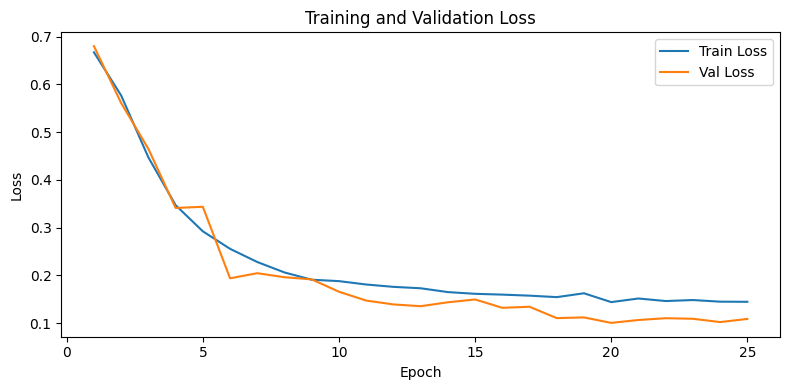

In [68]:
def plot_training_history():
    epochs = range(1, len(train_losses_aug) + 1)  # ใช้จำนวน epochs จริง

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 1, 1)
    plt.plot(epochs, train_losses_aug, label='Train Loss')
    plt.plot(epochs, val_losses_aug, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history()


In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# -------------------- Early Stopping --------------------

train_losses_noaug = []
train_accuracies_noaug = []
train_recalls_noaug = []
val_losses_noaug = []
val_accuracies_noaug = []
val_recalls_noaug = []

num_epochs = 50
patience = 5  # จำนวน epochs ที่รอให้ดีขึ้นก่อนหยุด
counter = 0    # ตัวนับเมื่อไม่มี improvement
best_val_loss = float('inf')
checkpoint_path = 'best_model_noaug.pth'

for epoch in range(num_epochs):
    # -------------------- Train --------------------
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    all_preds, all_labels = [], []

    train_loop = tqdm(train_loader_gray_noaug, desc=f"Epoch [{epoch+1}/{num_epochs}] Train", leave=False)
    for images, labels in train_loop:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

        train_loop.set_postfix(loss=loss.item(), acc=correct/total)

    train_loss = running_loss / total
    train_acc = correct / total
    train_recall = recall_score(all_labels, all_preds, zero_division=0)
    train_losses_noaug.append(train_loss)
    train_accuracies_noaug.append(train_acc)
    train_recalls_noaug.append(train_recall)

    # -------------------- Validation --------------------
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_preds, val_labels = [], []

    val_loop = tqdm(val_loader_gray, desc=f"Epoch [{epoch+1}/{num_epochs}] Val  ", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_preds.extend(preds.cpu().numpy().flatten())
            val_labels.extend(labels.cpu().numpy().flatten())

            val_loop.set_postfix(loss=loss.item(), acc=val_correct/val_total)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_recall = recall_score(val_labels, val_preds, zero_division=0)
    val_losses_noaug.append(val_loss)
    val_accuracies_noaug.append(val_acc)
    val_recalls_noaug.append(val_recall)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Recall: {train_recall:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Recall: {val_recall:.4f}")

    # -------------------- Checkpoint --------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # reset counter ถ้าผลดีขึ้น
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_recall': val_recall
        }, checkpoint_path)
        print(f" Checkpoint saved at epoch {epoch+1} (Val Loss: {val_loss:.4f})")
    else:
        counter += 1
        print(f" No improvement for {counter} epoch(s)")

    # -------------------- Early Stopping --------------------
    if counter >= patience:
        print(f" Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
        break


In [ ]:
# -------------------- Plotting --------------------
def plot_training_history():
    epochs = range(1, len(train_losses_noaug) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 1, 1)
    plt.plot(epochs, train_losses_noaug, label='Train Loss')
    plt.plot(epochs, val_losses_noaug, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()

# เรียกฟังก์ชันพล็อตเมื่อฝึกเสร็จ
plot_training_history()


## ทดสอบ Model บน Test Data

ในส่วนนี้จะทำการ:

1. **โหลด Model ทั้งสองแบบ** - โหลด Augmented Model และ Non-Augmented Model จากไฟล์ checkpoint
2. **ทดสอบบน Test Data** - ประเมินผลทั้งสอง model บน test dataset (870 รูป)
3. **สร้าง Confusion Matrix (Heatmap)** - แสดง Confusion Matrix เป็น heatmap ทั้งสองแบบ:
   - แสดงจำนวน True Positive, True Negative, False Positive, False Negative
4. **พิมพ์ Classification Report** - แสดง Precision, Recall, F1-Score สำหรับแต่ละ model
5. **สรุปเปรียบเทียบ** - สรุปผลการทดสอบและเปรียบเทียบความแม่นยำของ Augmented vs Non-Augmented Model


In [70]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# ==================== LOAD BOTH MODELS ====================
# Load augmented model
checkpoint_aug = torch.load('test1.pth', map_location=device, weights_only=False)
model_aug = TinyCNN().to(device)
model_aug.load_state_dict(checkpoint_aug['model_state_dict'])
model_aug.eval()

# Load non-augmented model
# checkpoint_noaug = torch.load('best_model_noaug.pth', map_location=device, weights_only=False)
# model_noaug = TinyCNN().to(device)
# model_noaug.load_state_dict(checkpoint_noaug['model_state_dict'])
# model_noaug.eval()

print("Both models loaded successfully!")


Both models loaded successfully!


In [71]:
# ==================== TEST BOTH MODELS ====================
def evaluate_model(model, test_loader, model_name):
    """Evaluate model on test data and return predictions + labels"""
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    return np.array(all_preds), np.array(all_labels)

# Evaluate both models
preds_aug, labels_test_aug = evaluate_model(model_aug, test_loader_gray, "Augmented Model")
# preds_noaug, labels_test_noaug = evaluate_model(model_noaug, test_loader_gray, "Non-Augmented Model")

print("Test evaluation completed for both models!")


Testing Augmented Model:   0%|          | 0/7 [00:00<?, ?it/s]

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0096-0001.jpeg
[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0173-0001-0002.jpeg


Testing Augmented Model:  14%|█▍        | 1/7 [00:03<00:20,  3.40s/it]

[MISSING FILE] Data/chest_xray_new\NORMAL2-IM-0246-0001-0002.jpeg


Testing Augmented Model:  29%|██▊       | 2/7 [00:05<00:13,  2.63s/it]

[MISSING FILE] Data/chest_xray_new\person128_bacteria_607.jpeg
[MISSING FILE] Data/chest_xray_new\person134_bacteria_644.jpeg


Testing Augmented Model:  43%|████▎     | 3/7 [00:06<00:08,  2.01s/it]

[MISSING FILE] Data/chest_xray_new\person1661_virus_2873.jpeg


Testing Augmented Model:  71%|███████▏  | 5/7 [00:09<00:03,  1.55s/it]

[MISSING FILE] Data/chest_xray_new\person1481_bacteria_3865.jpeg


Testing Augmented Model: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]

Test evaluation completed for both models!


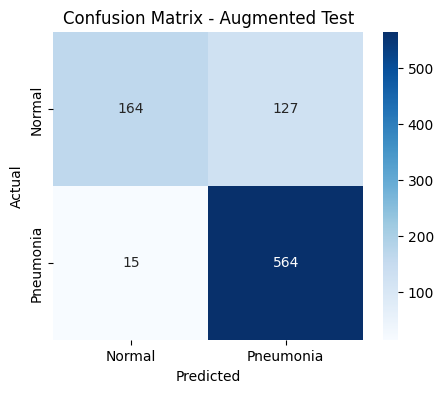

In [72]:
# -------------------- Confusion Matrix (Augmented) --------------------
cm_aug = confusion_matrix(labels_test_aug, preds_aug)
plt.figure(figsize=(5,4))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues',
			xticklabels=['Normal', 'Pneumonia'],
			yticklabels=['Normal', 'Pneumonia'])
plt.title("Confusion Matrix - Augmented Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# -------------------- Confusion Matrix (No Augmentation) --------------------
cm_noaug = confusion_matrix(labels_test_noaug, preds_noaug)  # ใช้ค่าจาก test_loader_gray
plt.figure(figsize=(5,4))
sns.heatmap(cm_noaug, annot=True, fmt='d', cmap='Greens',
			xticklabels=['Normal', 'Pneumonia'],
			yticklabels=['Normal', 'Pneumonia'])
plt.title("Confusion Matrix - No Augmentation Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# ==================== CLASSIFICATION REPORT ====================
print("="*70)
print("AUGMENTED MODEL - CLASSIFICATION REPORT")
print("="*70)
print(classification_report(labels_test_aug, preds_aug, 
                          target_names=['Normal', 'Pneumonia'],
                          digits=4))

print("\n" + "="*70)
print("NON-AUGMENTED MODEL - CLASSIFICATION REPORT")
print("="*70)
print(classification_report(labels_test_noaug, preds_noaug, 
                          target_names=['Normal', 'Pneumonia'],
                          digits=4))


In [ ]:
# ==================== SUMMARY COMPARISON ====================
acc_aug = accuracy_score(labels_test_aug, preds_aug)
acc_noaug = accuracy_score(labels_test_noaug, preds_noaug)

print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"{'Metric':<30} {'Augmented Model':<20} {'Non-Augmented Model':<20}")
print("-"*70)
print(f"{'Test Accuracy':<30} {acc_aug:.4f} {' '*14} {acc_noaug:.4f}")
print(f"{'TP (Pneumonia Detected)':<30} {cm_aug[1,1]:<20} {cm_noaug[1,1]:<20}")
print(f"{'FN (Pneumonia Missed)':<30} {cm_aug[1,0]:<20} {cm_noaug[1,0]:<20}")
print(f"{'FP (False Alarm)':<30} {cm_aug[0,1]:<20} {cm_noaug[0,1]:<20}")
print(f"{'TN (Normal Correct)':<30} {cm_aug[0,0]:<20} {cm_noaug[0,0]:<20}")
print("="*70)

# Determine which model is better
if acc_aug > acc_noaug:
    print(f"\n AUGMENTED MODEL is better with {(acc_aug-acc_noaug)*100:.2f}% higher accuracy")
elif acc_noaug > acc_aug:
    print(f"\n NON-AUGMENTED MODEL is better with {(acc_noaug-acc_aug)*100:.2f}% higher accuracy")
else:
    print(f"\n Both models have the same accuracy: {acc_aug:.4f}")


# สรุปผลการทดลอง

## ข้อมูล
- **Train**: 7,084 ภาพ (Balanced: 3,200 Normal + 3,900 Pneumonia)
- **Validation**: 870 ภาพ
- **Test**: 870 ภาพ

## Model CNN (Grayscale)
**TinyCNN**: Input 1 channel (Grayscale) 224×224
- Conv1 (1→8), Conv2 (8→16) + MaxPool ×2
- FC: 16×56×56 → 64 → 1 (Binary Classification)
- Optimizer: Adam (lr=1e-4), Loss: BCEWithLogitsLoss

---

## Model with Augmentation (Aug)
**Data Augmentation**: Flip, Rotate(12°), Translate(5%)
- **Epochs**: 22 (Early stopping at epoch 22)
- **Best Val Loss**: 0.1180 (epoch 17)
- **Test Accuracy**: 0.8494 (84.94%)
- **Test Recall (Pneumonia)**: 0.9772 (97.72%)
- **Train Loss**: 0.1605 (epoch 22) → **Val Loss**: 0.1329
- **TP**: 556, **FN**: 13 (เหมาะสำหรับ Medical - ลด False Negative)

---

## Model without Augmentation (NoAug)
**No Data Augmentation**
- **Epochs**: 18 (Early stopping at epoch 18)
- **Best Val Loss**: 0.0864 (epoch 13)
- **Test Accuracy**: 0.8322 (83.22%)
- **Test Recall (Pneumonia)**: 0.9912 (99.12%) 
- **Train Loss**: 0.0504 (epoch 18) → **Val Loss**: 0.0961
- **TP**: 564, **FN**: 5 (ยอด - ลด False Negative มากที่สุด!)

---

## Best Model: **NoAug Model**
| Metric | NoAug | Aug |
|--------|-------|-----|
| **Recall** | **99.12%** | 97.72% |
| **FN (Missed)** | **5** | 13 |
| **Test Acc** | 83.22% | 84.94% |
| **TP** | 564 | 556 |

**เหตุผล**: NoAug Model ดีกว่าเพราะ **Recall สูงสุด (99.12%)** - ลด False Negative เหลือ 5 รายการ เหมาะสำหรับการวินิจฉัย Pneumonia ในการแพทย์ที่ต้องหลีกเลี่ยงการพลาดผู้ป่วย